In [1]:
inpath = "/dls/i06-1/data/2025/cm40613-2//i06-1-353230.nxs"

# XMCD Notebook
Load a sequence of scans using a dummy scan to normalise, correct and subtract polarised x-ray absorption spectra.

```python
scan dummy -5 -1 1 xmcd_processor  # assumes previous 4 scans were energy scans at different polarisations
```

[mmg_toolbox](https://github.com/DanPorter/mmg_toolbox) is in active development and likely to change in the future, therefore please don't rely to heavily on the functions at this point. You can see how everything works at the repository. If you have any comments, please do get in touch!

In [2]:
import sys, os
import matplotlib.pyplot as plt


import hdfmap
print(hdfmap.module_info())
hdfmap.set_all_logging_level('error')

from mmg_toolbox.utils.file_functions import get_scan_number, replace_scan_number
# from mmg_toolbox.spectra_scan import Scan, SubtractPolarisations, split_polarisations
from mmg_toolbox.spectra_scan2 import SpectraScan, find_pol_pairs, is_nxxas


Python version 3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:24) [GCC 13.3.0]
 at: /scratch/grp66007/software/miniforge/envs/mmg_data_analysis/bin/python
 hdfmap version 0.9.0 (2025/03/31): /scratch/grp66007/software/miniforge/envs/mmg_data_analysis/lib/python3.10/site-packages/hdfmap/__init__.py
     numpy version: 2.1.2
      h5py version: 3.12.1
    hdf5plugin: 5.0.0
Running in directory: /scratch/grp66007/python/mmg_toolbox/notebooks



In [6]:
# Get scan numbers
nxs_map = hdfmap.create_nexus_map(inpath)  # inpath is injected as the first cell by the processor

with nxs_map.load_hdf() as nxs:
    scan_numbers = nxs_map.eval(nxs, 'axes')  # return the list of dummy values as array
    cmd = nxs_map.eval(nxs, 'scan_command')

scan_number = get_scan_number(inpath)  # scan number from filename
print('Dummy scan:')
print(f"{os.path.basename(inpath)}  scan_number = {scan_number}, cmd = '{cmd}'\n")

# handle relative scan numbers (0 is current scan)
scan_numbers = [n if n > 100 else scan_number + n for n in scan_numbers]
scan_numbers = [353227, 353233]
scan_files = [replace_scan_number(inpath, int(n)) for n in scan_numbers]
check = [is_nxxas(file) for file in scan_files]

print('Check files:')
print('\n'.join(f"{file}: {ok}" for file, ok in zip(scan_files, check)))

if not all(check):
    raise Exception("Some files don't exist or are not NXxas scans!")


Dummy scan:
i06-1-353230.nxs  scan_number = 353230, cmd = 'scan ds -2 -1 1 xmcd_processor'

Check files:
/dls/i06-1/data/2025/cm40613-2/i06-1-353227.nxs: True
/dls/i06-1/data/2025/cm40613-2/i06-1-353233.nxs: True


SpectraScan<353227, pol='pc')>
  tey: Spectra('353227 pc tey', energy=array(250,), signal=array(250,), process=raw)
  tfy: Spectra('353227 pc tfy', energy=array(250,), signal=array(250,), process=raw)
  Metadata:
   scan: i06-1-353227.nxs
   cmd: scan fastEnergy 0.0 249.0 1.0 fesData 0.0 1.0
   title: --
   endstation: magnet
   sample: name not given
   pol: pc
   temperature: 297.14 K
   field: 0.00 T 

SpectraScan<353233, pol='unknown')>
  tey: Spectra('353233 unknown tey', energy=array(250,), signal=array(250,), process=raw)
  tfy: Spectra('353233 unknown tfy', energy=array(250,), signal=array(250,), process=raw)
  Metadata:
   scan: i06-1-353233.nxs
   cmd: scan fastEnergy 0.0 249.0 1.0 fesData 0.0 1.0
   title: --
   endstation: magnet
   sample: name not given
   pol: unknown
   temperature: 297.26 K
   field: 0.00 T 



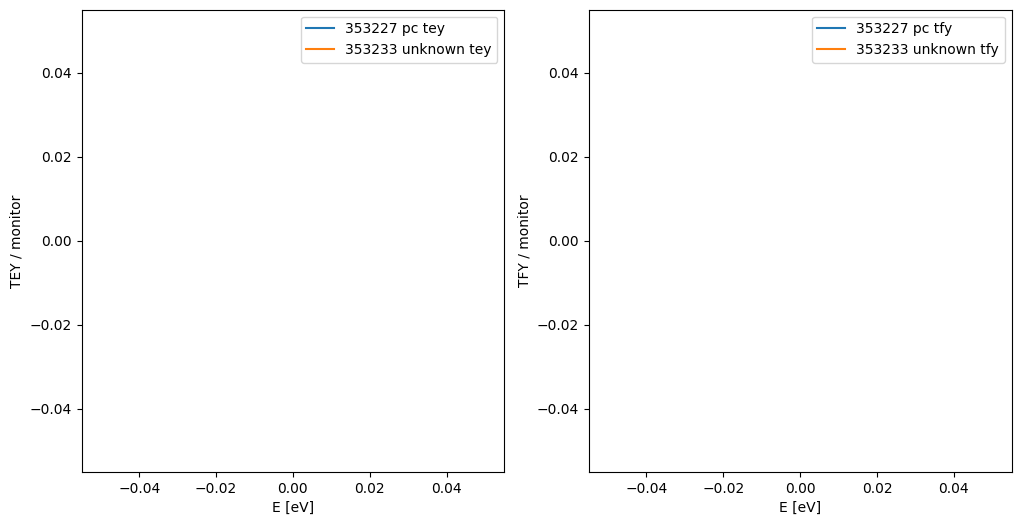

In [12]:
# Load scan data and plot raw spectra
scans = [SpectraScan(file) for file in scan_files]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 6], dpi=100)
for scan in scans:
    print(scan, '\n')
    scan.tey.plot(ax1)
    scan.tfy.plot(ax2)

ax1.set_xlabel('E [eV]')
ax1.set_ylabel('TEY / monitor')
ax2.set_xlabel('E [eV]')
ax2.set_ylabel('TFY / monitor')
ax1.legend()
ax2.legend()

SpectraProcess('XMCD', [SpectraScan<353233, pol='unknown')>, SpectraScan<353227, pol='pc')>])


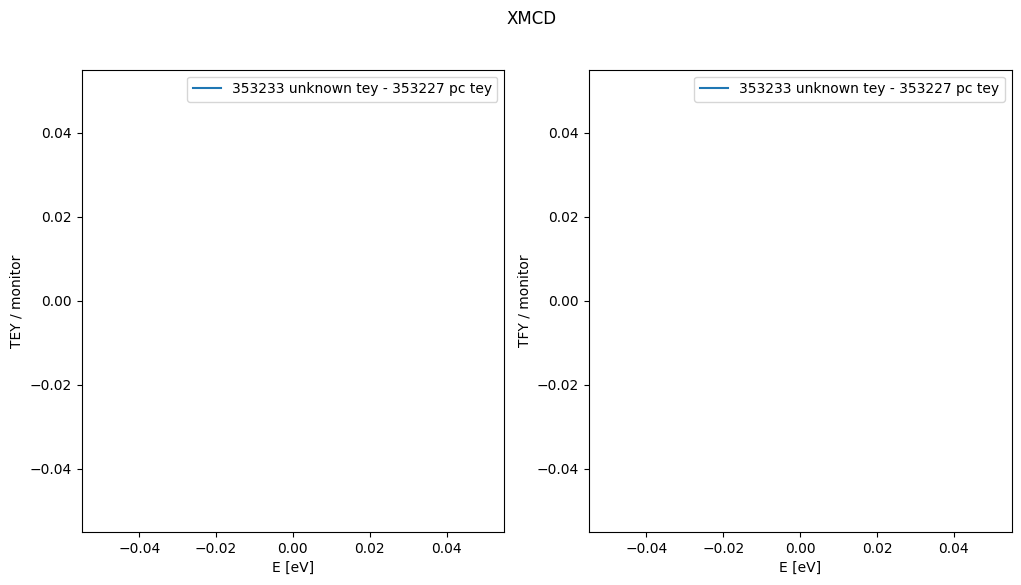

In [10]:
# Find polarisation pairs and plot difference of raw spectra
pairs = find_pol_pairs(*scans)
for pair in pairs:
    print(pair)

    # pair.create_figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 6], dpi=100)
    fig.suptitle(pair.description)

    pair.spectra1.tey.plot_parents(ax1)  # background subtracted spectra
    pair.spectra2.tey.plot_parents(ax1)
    pair.tey.plot(ax1)  # XMCD/XMLD

    pair.spectra1.tey.plot_parents(ax2)
    pair.spectra2.tey.plot_parents(ax2)
    pair.tey.plot(ax2)

    ax1.set_xlabel('E [eV]')
    ax1.set_ylabel('TEY / monitor')
    ax2.set_xlabel('E [eV]')
    ax2.set_ylabel('TFY / monitor')
    ax1.legend()
    ax2.legend()

SpectraProcess('XMCD', [SpectraProcess('norm to jump', [SpectraProcess('flat', [SpectraScan<353233, pol='unknown')>])]), SpectraProcess('norm to jump', [SpectraProcess('flat', [SpectraScan<353227, pol='pc')>])])])


/scratch/grp66007/python/mmg_toolbox/mmg_toolbox/spectra_analysis.py:71: RuntimeWarning: invalid value encountered in subtract
  return np.subtract(signal, bkg), bkg * np.ones_like(signal)


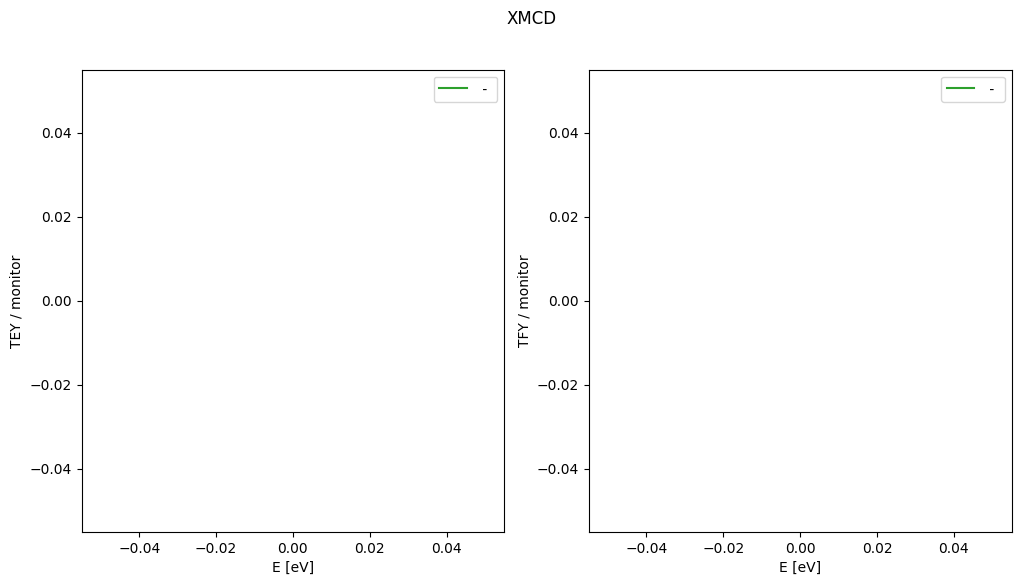

In [11]:
# Subtract background and normalise
# background options: flat, norm, linear, curve, exp
# normalisation option: .norm_to_jump(), .norm_to_peak()
rem_bkg = [s.remove_background('flat').norm_to_jump() for s in scans]
pairs = find_pol_pairs(*rem_bkg)

for pair in pairs:
    print(pair)

    # pair.create_figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 6], dpi=100)
    fig.suptitle(pair.description)

    pair.spectra1.tey.plot_parents(ax1)  # background subtracted spectra
    pair.spectra2.tey.plot_parents(ax1)
    pair.tey.plot(ax1)  # XMCD/XMLD

    pair.spectra1.tey.plot_parents(ax2)
    pair.spectra2.tey.plot_parents(ax2)
    pair.tey.plot(ax2)

    ax1.set_xlabel('E [eV]')
    ax1.set_ylabel('TEY / monitor')
    ax2.set_xlabel('E [eV]')
    ax2.set_ylabel('TFY / monitor')
    ax1.legend()
    ax2.legend()

SpectraProcess('XMCD', [SpectraProcess('norm to jump', [SpectraProcess('flat', [SpectraScan<353233, pol='unknown')>])]), SpectraProcess('norm to jump', [SpectraProcess('flat', [SpectraScan<353227, pol='pc')>])])])


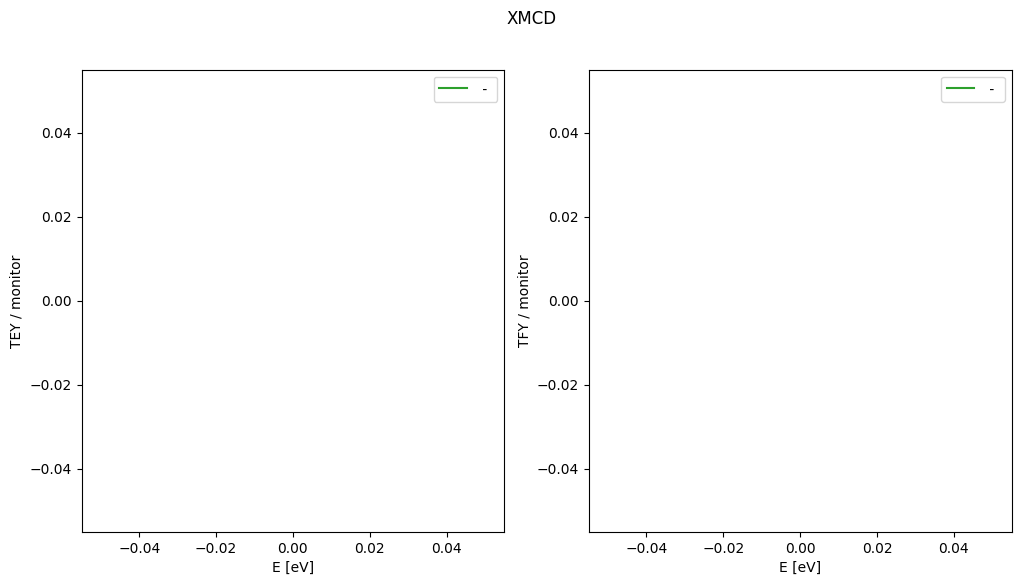

In [15]:
# Average each polarisation of all scans
pol1 = [pair.spectra1 for pair in pairs]
pol2 = [pair.spectra2 for pair in pairs]
av_pol1 = sum(pol1[1:], pol1[0])
av_pol2 = sum(pol2[1:], pol2[0])
diff = av_pol1 - av_pol2
print(diff)

# diff.create_figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 6], dpi=100)
fig.suptitle(diff.description)

diff.spectra1.tey.plot_parents(ax1)
diff.spectra2.tey.plot_parents(ax1)
diff.tey.plot(ax1)

diff.spectra1.tey.plot_parents(ax2)
diff.spectra2.tey.plot_parents(ax2)
diff.tey.plot(ax2)

ax1.set_xlabel('E [eV]')
ax1.set_ylabel('TEY / monitor')
ax2.set_xlabel('E [eV]')
ax2.set_ylabel('TFY / monitor')
ax1.legend()
ax2.legend()